In [1]:
# haandle data
import json
import operator
import collections
# https://docs.python.org/3/library/re.html
import re # regular expression

In [2]:
# handle table data
import numpy as np
import pandas as pd

In [4]:
# algorithms
# https://rare-technologies.com/word2vec-tutorial/
from gensim.models import word2vec
# modeling helpers
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
# tool to visualize high-dimensional data. 
from sklearn.manifold import TSNE

In [5]:
# Visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [7]:
trainrecipts = json.load(open('./data/train.json','r'))

In [8]:
raw_ingredients = list()

for recipt in trainrecipts:
    for ingredient in recipt[u'ingredients']:
        raw_ingredients.append(ingredient.strip())
        

raw_cuisines = list()
for recipt in trainrecipts:
    raw_cuisines.append(recipt[u'cuisine'].strip())

In [9]:
# use Counter to get frequencies 
counts_ingr = collections.Counter(raw_ingredients)
counts_cuis = collections.Counter(raw_cuisines)

In [10]:
# this will help us to have an idea how our corpora of 
# ingredients looks like
print('Size Ingredients dataset (with repetition):  \t{}'.format((len(raw_ingredients))))
print('Unique Ingredients dataset: \t\t\t{}'.format((len(counts_ingr.values()))))

# This will provide a distribution of cusines, indirect 
# info of the ingredients
print('Total # of recipts \t\t\t\t{}'.format(len(raw_cuisines)))
print('Total # of Cuisines \t\t\t\t{}'.format((len(counts_cuis.values()))))

Size Ingredients dataset (with repetition):  	428275
Unique Ingredients dataset: 			6714
Total # of recipts 				39774
Total # of Cuisines 				20


In [11]:
# top 10
counts_cuis.most_common(10)

[('italian', 7838),
 ('mexican', 6438),
 ('southern_us', 4320),
 ('indian', 3003),
 ('chinese', 2673),
 ('french', 2646),
 ('cajun_creole', 1546),
 ('thai', 1539),
 ('japanese', 1423),
 ('greek', 1175)]

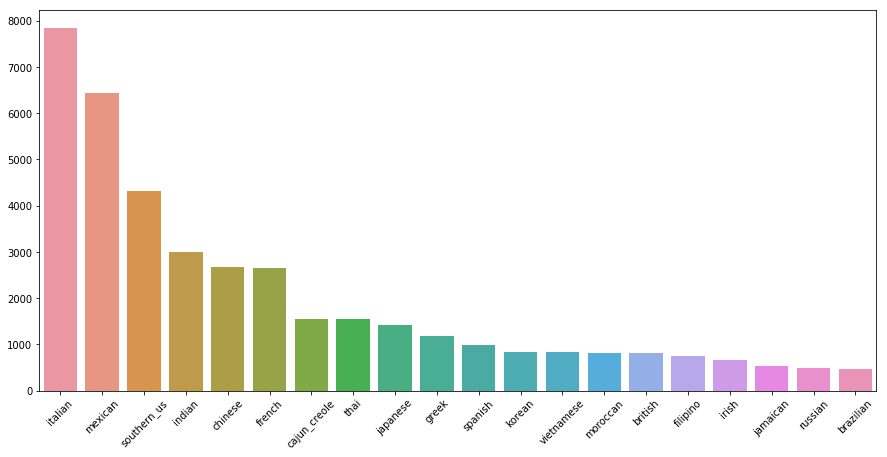

In [13]:
# sort
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
x_cu = [cu for cu, frq in counts_cuis.most_common()]
y_frq = [frq for cu, frq in counts_cuis.most_common()]
fbar = sns.barplot(x = x_cu, y = y_frq)

In [14]:
# init a dict with a empty list
num_ingredients = dict(zip(counts_cuis.keys(), [list() for x in counts_cuis.keys()]))
for recipt in trainrecipts:
    # append the number in the list
    num_ingredients[recipt['cuisine']].append(len(recipt['ingredients']))

print(len(num_ingredients))

20


In [19]:
for cu, frq in num_ingredients.items():
    print('{:20}    {:.2f}'.format(cu, np.mean(frq)))

greek                   10.18
southern_us             9.63
filipino                10.00
indian                  12.71
jamaican                12.21
spanish                 10.42
italian                 9.91
mexican                 10.88
chinese                 11.98
british                 9.71
thai                    12.55
vietnamese              12.68
cajun_creole            12.62
brazilian               9.52
french                  9.82
japanese                9.74
irish                   9.30
korean                  11.28
moroccan                12.91
russian                 10.22


In [20]:
# top 15
counts_ingr.most_common(15)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113)]

In [23]:
# Tail 50
counts_ingr.most_common()[-10:]

[('Oscar Mayer Cotto Salami', 1),
 ('Challenge Butter', 1),
 ('orange glaze', 1),
 ('cholesterol free egg substitute', 1),
 ('ciabatta loaf', 1),
 ('LiptonÂ® Iced Tea Brew Family Size Tea Bags', 1),
 ('Hidden ValleyÂ® Greek Yogurt Original RanchÂ® Dip Mix', 1),
 ('lop chong', 1),
 ('tomato garlic pasta sauce', 1),
 ('crushed cheese crackers', 1)]

In [24]:
symbols = list()

for recipt in trainrecipts:

    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        if re.match("\(|@|\$\?", ingredient.lower()):
            symbols.append(ingredient)
len(symbols)
counts_symbols = collections.Counter(symbols)
counts_symbols.most_common(20)

[('(    oz.) tomato sauce', 11),
 ('(   oz.) tomato paste', 9),
 ('(14.5 oz.) diced tomatoes', 3),
 ('(15 oz.) refried beans', 3),
 ('(10 oz.) frozen chopped spinach', 3),
 ('(10 oz.) frozen chopped spinach, thawed and squeezed dry', 2),
 ('(14 oz.) sweetened condensed milk', 2)]

In [25]:
# remove key words and adjectives
sentences = list()
# one hot ingredients


for recipt in trainrecipts:
    clean_recipt = list()
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        # remove this description from the ingredients
        # minimal preprocessing
        ingredient =  re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced',
                             '', 
                             ingredient)
        clean_recipt.append(ingredient.strip())
    sentences.append(clean_recipt)
        
len(sentences)

39774

In [28]:
print(sentences[0])

['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese']


In [26]:
# Set values for NN parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 3    # 50% of the corpus                    
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 
                      # let's use avg recipte size                                                                                  
downsampling = 1e-3   # threshold for configuring which 
                    # higher-frequency words are randomly downsampled

In [29]:
# initalize model 
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

In [30]:
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

In [33]:
model.wv.most_similar('feta cheese')

c:\users\faroo\documents\kaggle_project\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('kalamata', 0.9325991272926331),
 ('olives', 0.9132055640220642),
 ('pitted kalamata olives', 0.9127309322357178),
 ('fresh oregano', 0.911074161529541),
 ('roasted red peppers', 0.9001317024230957),
 ('pitas', 0.8930472135543823),
 ('grape tomatoes', 0.8924123048782349),
 ('greek seasoning', 0.8898167610168457),
 ('cherry tomatoes', 0.8734899759292603),
 ('pitted black olives', 0.8622173070907593)]

In [35]:
model.wv.similarity('broccoli', 'bacon')

c:\users\faroo\documents\kaggle_project\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.36447132

AttributeError: 'Word2Vec' object has no attribute 'predict'